# Set the Working Directory

In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


# Load Libraries

In [2]:
import elapid as ela
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rxr
from sdm.geo import generate_model_raster
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from elapid import MaxentModel, GeographicKFold, distance_weights
from sdm.maxent import prepare_occurence_data, filter_bats, extract_split, cv_maxent, train_maxent, filter_gdf_to_grid

# Grid

I only want to keep one point for each species in each 100m grid square. I'm going to do this by loading the model raster which is a null raster which all the predictors are modelled on. I'll convert it to a geodataframe and then take the inner spatial join between the nearest points with a threshold of 100m.

In [3]:
def generate_point_grid():
    model_raster = generate_model_raster()
    # Cooridinates represent the center of each pixel
    grid_df = model_raster.to_dataframe(name = "random").reset_index()
    grid_points = gpd.GeoDataFrame(grid_df, geometry = gpd.points_from_xy(grid_df.x, grid_df.y), crs = 27700)
    # Only keep the geometry column
    grid_points = grid_points[["geometry"]]
    return grid_points

grid_points = generate_point_grid()

grid_points.head()


/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


,geometry
0,POINT (403914.879 426796.146)
1,POINT (404014.948 426796.146)
2,POINT (404115.017 426796.146)
3,POINT (404215.086 426796.146)
4,POINT (404315.154 426796.146)


# Bat Records & Background Points


In [4]:
bats = gpd.read_parquet('data/processed/sybg-bats.parquet')
bats.head()

,date,grid_reference,species_raw,activity_type,source_data,latin_name,common_name,genus,x,y,accuracy,geometry,grid_square_geom
0,2010-05-17 00:00:00,NZ115084,Common pipistrelle,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1274054400000,""Gr...",Pipistrellus pipistrellus,Common Pipistrelle,Pipistrellus,411550.0,508450.0,100.0,POINT (411550.000 508450.000),"POLYGON ((411600.000 508400.000, 411600.000 50..."
1,2014-07-03 00:00:00,NZ14640021,Pipistrellus sp.,Unknown,"{""Recorder"":""Giles Manners"",""Date"":14043456000...",Pipistrellus sp.,Unidentified Pipistrelle,Pipistrellus,414645.0,500215.0,10.0,POINT (414645.000 500215.000),"POLYGON ((414650.000 500210.000, 414650.000 50..."
2,2013-11-28 00:00:00,NZ20291106,Soprano pipistrelle,Unknown,"{""Recorder"":""Natural England Volunteer Bat Roo...",Pipistrellus pygmaeus,Soprano Pipistrelle,Pipistrellus,420295.0,511065.0,10.0,POINT (420295.000 511065.000),"POLYGON ((420300.000 511060.000, 420300.000 51..."
3,2010-08-31 00:00:00,NZ170014,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1283212800000,""Gr...",Unknown,Unidentified Bat,Unknown,417050.0,501450.0,100.0,POINT (417050.000 501450.000),"POLYGON ((417100.000 501400.000, 417100.000 50..."
4,2009-05-20 00:00:00,NZ185116,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1242777600000,""Gr...",Unknown,Unidentified Bat,Unknown,418550.0,511650.0,100.0,POINT (418550.000 511650.000),"POLYGON ((418600.000 511600.000, 418600.000 51..."


In [5]:
latin_name = [
 'Pipistrellus pipistrellus',
 'Pipistrellus pygmaeus',
 'Plecotus auritus',
 'Myotis mystacinus',
 'Nyctalus noctula',
 'Myotis daubentonii',
 'Myotis nattereri',
 'Nyctalus leisleri',
 'Myotis brandtii',
 'Pipistrellus nathusii',
 'Eptesicus serotinus'
]

activity_type = [
    'Foraging',
    'Roost',
    None # Don't filters activity type
]

genus = [
    'Pipistrellus',
    'Plecotus',
    'Myotis',
    'Nyctalus',
    'Eptesicus'
]


In [6]:
bats = bats[bats.accuracy <= 100]


This function will be used once the data has been filtered to the right combination of species and behaviour to keep only the records which are unique to each 100m grid square.

In [7]:
background = gpd.read_parquet('data/processed/background-points.parquet')
background = background[["geometry"]]
background.head()

,geometry
363752,POINT (472223.236 416517.648)
83313,POINT (429711.807 381022.722)
171177,POINT (436034.552 392150.867)
324861,POINT (459022.462 411539.652)
281490,POINT (472438.437 406093.802)


I'm going to build a series of models based upon different taxonomic and behaviour classifications. I will build a model for:
- Each species and any behaviour type
- Each species and roosting or foraging
- Each genus and any behaviour type
- Each genus and roosting or foraging

# Point Annotation

In [8]:
from pathlib import Path

def load_evs(ev_folder:Path):
    # list the tifs
    ev_tifs = list(ev_folder.glob("*.tif"))

    #path = ev_tifs[0]
    def load_dataset(path):
        data = rxr.open_rasterio(path)
        # Extract the band name
        long_name = data.attrs["long_name"]
        if type(long_name) == str:
            long_name = [long_name]
        else:
            long_name = list(long_name)
        
        # prefix the band name with the file name
        long_name = [f"{path.stem}_{name}" for name in long_name]

        # Rename the band dimension and convert to a dataset
        data.coords["band"] = long_name
        return data.to_dataset(dim="band")

    evs = [load_dataset(path) for path in ev_tifs]

    evs = xr.merge(evs)

    return evs
ev_folder = Path("data/evs/")
evs = load_evs(ev_folder)
evs

<xarray.Dataset>
Dimensions:                                         (y: 563, x: 792)
Coordinates:
  * x                                               (x) float64 4.039e+05 ......
  * y                                               (y) float64 4.268e+05 ......
    spatial_ref                                     int64 0
Data variables: (12/107)
    climate_stats_temp_ann_var                      (y, x) float64 ...
    climate_stats_temp_ann_avg                      (y, x) float64 ...
    climate_stats_temp_mat_avg                      (y, x) float64 ...
    climate_stats_prec_ann_var                      (y, x) float64 ...
    climate_stats_prec_ann_avg                      (y, x) float64 ...
    climate_stats_wind_ann_var                      (y, x) float64 ...
    ...                                              ...
    ceh-land-cover-100m_Littoral rock               (y, x) float64 ...
    ceh-land-cover-100m_Littoral sediment           (y, x) float64 ...
    ceh-land-cover-100m_Saltmarsh                   (y, x) float64 ...
    ceh-land-cover-100m_Urban                       (y, x) float64 ...
    ceh-land-cover-100m_Suburban                    (y, x) float64 ...
    dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation  (y, x) float32 ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('temp_ann_var', 'temp_ann_avg', 'temp_mat_avg', 'prec_an...

Many of the environmental variables are highly correlated with each other so I will only use a subset in the modelling

In [9]:
ev_subset_df = pd.read_csv("data/evs/ev_clusters_selected.csv")
keep_evs = ev_subset_df[ev_subset_df.include == 1].column_name.tolist()

# Subset the xr dataset to  only include the variables with the keep evs names
evs_to_model = evs[keep_evs]
evs_to_model

<xarray.Dataset>
Dimensions:                                         (y: 563, x: 792)
Coordinates:
  * x                                               (x) float64 4.039e+05 ......
  * y                                               (y) float64 4.268e+05 ......
    spatial_ref                                     int64 0
Data variables: (12/31)
    climate_stats_wind_ann_avg                      (y, x) float64 ...
    dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation  (y, x) float32 ...
    climate_stats_temp_ann_avg                      (y, x) float64 ...
    climate_stats_prec_ann_avg                      (y, x) float64 ...
    bioclim_bioclim_15                              (y, x) float32 ...
    os-distance-to-feature_distance_to_buildings    (y, x) float64 ...
    ...                                              ...
    ceh-land-cover-100m_Calcareous grassland        (y, x) float64 ...
    os-distance-to-feature_distance_to_major_roads  (y, x) float64 ...
    ceh-land-cover-100m_Urban                       (y, x) float64 ...
    os-distance-to-feature_distance_to_water        (y, x) float64 ...
    ceh-land-cover-100m_Improved grassland          (y, x) float64 ...
    ceh-land-cover-100m_Coniferous woodland         (y, x) float64 ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('temp_ann_var', 'temp_ann_avg', 'temp_mat_avg', 'prec_an...

In [10]:
## Annotate points
from tempfile import NamedTemporaryFile
temp_ev_raster =  NamedTemporaryFile(suffix = ".tif", delete=False)
# Write the EVs to a temporary file and annotate the background and presence points

evs_to_model.rio.to_raster(temp_ev_raster.name)


ev_columns = list(evs_to_model.data_vars.keys())
bats_ant = ela.annotate(
    bats, 
    temp_ev_raster.name, 
    labels = ev_columns,
)
background = ela.annotate(
    background, 
    temp_ev_raster.name, 
    labels = ev_columns,
)

Raster:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/9316 [00:00<?, ?it/s]

Raster:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

In [11]:
bats_ant.head()

,date,grid_reference,species_raw,activity_type,source_data,latin_name,common_name,genus,x,y,...,ceh-land-cover-100m_Heather grassland,ceh-land-cover-100m_Inland rock,ceh-land-cover-100m_Suburban,ceh-land-cover-100m_Neutral grassland,ceh-land-cover-100m_Calcareous grassland,os-distance-to-feature_distance_to_major_roads,ceh-land-cover-100m_Urban,os-distance-to-feature_distance_to_water,ceh-land-cover-100m_Improved grassland,ceh-land-cover-100m_Coniferous woodland
0,2010-05-17 00:00:00,NZ115084,Common pipistrelle,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1274054400000,""Gr...",Pipistrellus pipistrellus,Common Pipistrelle,Pipistrellus,411550.0,508450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-07-03 00:00:00,NZ14640021,Pipistrellus sp.,Unknown,"{""Recorder"":""Giles Manners"",""Date"":14043456000...",Pipistrellus sp.,Unidentified Pipistrelle,Pipistrellus,414645.0,500215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-11-28 00:00:00,NZ20291106,Soprano pipistrelle,Unknown,"{""Recorder"":""Natural England Volunteer Bat Roo...",Pipistrellus pygmaeus,Soprano Pipistrelle,Pipistrellus,420295.0,511065.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-08-31 00:00:00,NZ170014,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1283212800000,""Gr...",Unknown,Unidentified Bat,Unknown,417050.0,501450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009-05-20 00:00:00,NZ185116,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1242777600000,""Gr...",Unknown,Unidentified Bat,Unknown,418550.0,511650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

Modelling process:
1. Filter to the species and behaviour type
2. Get the unique points in each 100m grid square
3. Calculate the distance weights for the points
4. Define the model and fit using Cross Validation
5. Save the model

In [12]:
# initialize and print the model defaults
from pprint import pprint


def maxent_model(n_jobs = 1):
    maxent = ela.MaxentModel()

    model = Pipeline(
        [
        #   ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("maxent", MaxentModel(
                feature_types = ["linear", "product", "threshold"],
                beta_multiplier = 2,
                beta_lqp = 1.5,
                n_cpus = n_jobs,
            )),
        ]
    )
    return model

In [13]:
ela.MaxentModel().get_params()

{'beta_categorical': 1.0,
 'beta_hinge': 1.0,
 'beta_lqp': 1.0,
 'beta_multiplier': 1.5,
 'beta_threshold': 1.0,
 'clamp': True,
 'class_weights': 100,
 'convergence_tolerance': 2e-06,
 'feature_types': ['linear', 'hinge', 'product'],
 'n_cpus': 10,
 'n_hinge_features': 10,
 'n_lambdas': 100,
 'n_threshold_features': 10,
 'scorer': 'roc_auc',
 'tau': 0.5,
 'transform': 'cloglog',
 'use_lambdas': 'best',
 'use_sklearn': True}

In [14]:
import numpy as np
presence = filter_bats(bats_ant, latin_name = "Plecotus auritus", activity_type = "Foraging")

occurrence = prepare_occurence_data(
    presence, 
    background,
    grid_points,
    input_vars = ev_columns,
    
)

models, scores = cv_maxent(
    model = maxent_model(),
    occurrence = occurrence
)

mean_score = np.mean(scores)
std_score = np.std(scores)
print(f"Mean AUC: {mean_score} +/- {std_score}")

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Mean AUC: 0.6078546137137734 +/- 0.03659586855834261


In [15]:
# Male some predictions
path_predict = Path("data/sdm_predictions/temp/test.tif")
ela.apply_model_to_rasters(
    models[0], 
    temp_ev_raster.name,
    output_path = path_predict

)

Window:   0%|                              | 0/563 [00:00<?, ?it/s]

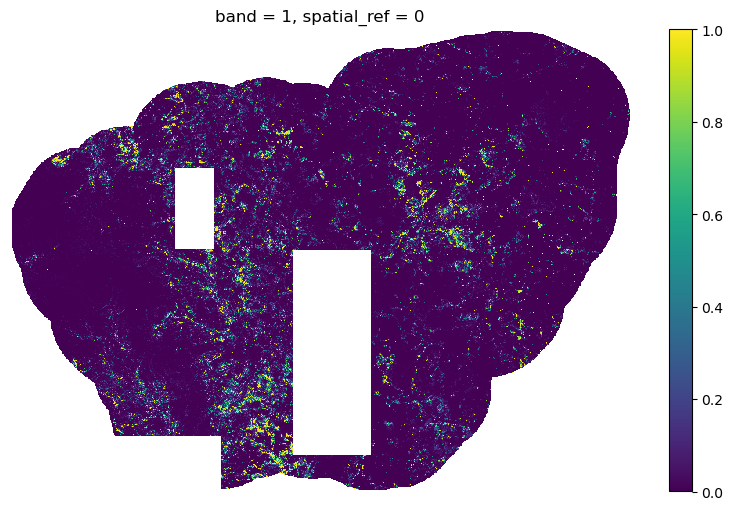

In [16]:
import matplotlib.pyplot as plt
predictions = rxr.open_rasterio(path_predict)
# plot 
fig, ax = plt.subplots(figsize=(10, 6))
predictions.plot(ax=ax, cmap="viridis")
ax.set_axis_off()
plt.show()

In [17]:
# Make a leafmap
import leafmap
m = leafmap.Map()
m.add_basemap("HYBRID")
m.add_raster(str(path_predict), layer_name = "Predictions", cmap = "viridis")
m.add_gdf(presence[["geometry"]], layer_name = "Presence")
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

# Build all models

In [18]:
# Generate every combination of latin name and activity type
from itertools import product

# Generate all combinations of latin name and activity type
filter_combinations = list(product(latin_name, activity_type))

In [19]:
def eval_train_model(occurence):
    models, scores = cv_maxent(
        model = maxent_model(),
        occurrence = occurence
    )
        # Train a model on all the data
    full_model = train_maxent(
        model=maxent_model(n_jobs=10),
        occurrence=occurrence,
    )
    return full_model, models, scores

In [24]:
results = []
from tqdm import tqdm

for latin_name, activity_type in tqdm(filter_combinations):
    presence = filter_bats(bats_ant, latin_name=latin_name, activity_type=activity_type)

    if len(presence) < 15:
        continue

    occurrence = prepare_occurence_data(
        presence, background, grid_points, input_vars=ev_columns
    )

    cv_models, cv_scores = cv_maxent(
        model=maxent_model(n_jobs=10),
        occurrence=occurrence,
        folds = 3,
        
    )

    # Train a model on all the data
    model = train_maxent(
        model=maxent_model(n_jobs=10),
        occurrence=occurrence,
    )

    mean_score = cv_scores.mean()
    std_score = cv_scores.std()

    best_model = models[scores.argmax()]

    results.append(
        {
            "latin_name": latin_name,
            "activity_type": activity_type,
            "n_presence": len(presence),
            "n_background": len(background),
            "folds": len(cv_scores),
            "mean_score": mean_score,
            "std_score": std_score,
            "best_model": best_model,
            "params": best_model.get_params(),
        }
    )


results_df = pd.DataFrame(results)


  0%|          | 0/33 [00:00<?, ?it/s]

In [21]:
results_df

,latin_name,activity_type,n_presence,n_background,folds,mean_score,std_score,best_model,params
0,Pipistrellus pipistrellus,Foraging,2454,10000,3,0.607855,0.036596,"(StandardScaler(), MaxentModel(beta_lqp=1.5, b...","{'memory': None, 'steps': [('scaler', Standard..."
1,Pipistrellus pipistrellus,Roost,559,10000,3,0.607855,0.036596,"(StandardScaler(), MaxentModel(beta_lqp=1.5, b...","{'memory': None, 'steps': [('scaler', Standard..."
2,Pipistrellus pipistrellus,None,3349,10000,3,0.607855,0.036596,"(StandardScaler(), MaxentModel(beta_lqp=1.5, b...","{'memory': None, 'steps': [('scaler', Standard..."
3,Pipistrellus pygmaeus,Foraging,319,10000,3,0.607855,0.036596,"(StandardScaler(), MaxentModel(beta_lqp=1.5, b...","{'memory': None, 'steps': [('scaler', Standard..."
4,Pipistrellus pygmaeus,Roost,113,10000,3,0.607855,0.036596,"(StandardScaler(), MaxentModel(beta_lqp=1.5, b...","{'memory': None, 'steps': [('scaler', Standard..."
5,Pipistrellus pygmaeus,None,519,10000,3,0.607855,0.036596,"(StandardScaler(), MaxentModel(beta_lqp=1.5, b...","{'memory': None, 'steps': [('scaler', Standard..."
6,Plecotus auritus,Foraging,74,10000,3,0.607855,0.036596,"(StandardScaler(), MaxentModel(beta_lqp=1.5, b...","{'memory': None, 'steps': [('scaler', Standard..."
7,Plecotus auritus,Roost,305,10000,3,0.607855,0.036596,"(StandardScaler(), MaxentModel(beta_lqp=1.5, b...","{'memory': None, 'steps': [('scaler', Standard..."
8,Plecotus auritus,None,493,10000,3,0.607855,0.036596,"(StandardScaler(), MaxentModel(beta_lqp=1.5, b...","{'memory': None, 'steps': [('scaler', Standard..."
9,Myotis mystacinus,Foraging,21,10000,3,0.607855,0.036596,"(StandardScaler(), MaxentModel(beta_lqp=1.5, b...","{'memory': None, 'steps': [('scaler', Standard..."


In [22]:
results_df.activity_type.fillna("Any", inplace=True)
results_df.to_csv("data/sdm_predictions/results.csv", index=False)

In [23]:
# Iterate through the df and make predictions using the best model
# save each prediction to a tif named after the latin name and activity type

for _, row in results_df.iterrows():
    latin_name = row.latin_name
    activity_type = row.activity_type
    best_model = row.best_model

    path_predict = Path(f"data/sdm_predictions/{latin_name}_{activity_type}.tif")
    ela.apply_model_to_rasters(
        best_model, 
        temp_ev_raster.name,
        output_path = path_predict,
        windowed = False,
    )

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

Window:   0%|                              | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
paths = list(Path("data/sdm_predictions/").glob("*.tif"))
paths

[PosixPath('data/sdm_predictions/Myotis brandtii_Any.tif'),
 PosixPath('data/sdm_predictions/Pipistrellus pygmaeus_Any.tif'),
 PosixPath('data/sdm_predictions/Pipistrellus pipistrellus_Roost.tif'),
 PosixPath('data/sdm_predictions/Nyctalus noctula_Any.tif'),
 PosixPath('data/sdm_predictions/Plecotus auritus_Roost.tif'),
 PosixPath('data/sdm_predictions/Myotis mystacinus_Any.tif'),
 PosixPath('data/sdm_predictions/Myotis nattereri_Foraging.tif'),
 PosixPath('data/sdm_predictions/Nyctalus noctula_Roost.tif'),
 PosixPath('data/sdm_predictions/Myotis nattereri_Any.tif'),
 PosixPath('data/sdm_predictions/Pipistrellus pygmaeus_Roost.tif'),
 PosixPath('data/sdm_predictions/Pipistrellus pygmaeus_Foraging.tif'),
 PosixPath('data/sdm_predictions/Myotis nattereri_Roost.tif'),
 PosixPath('data/sdm_predictions/Nyctalus leisleri_Roost.tif'),
 PosixPath('data/sdm_predictions/Plecotus auritus_Any.tif'),
 PosixPath('data/sdm_predictions/Myotis daubentonii_Any.tif'),
 PosixPath('data/sdm_predictions/Nyc

In [ ]:
selected_path = paths[2]
print(f"Mapping predictions for {selected_path.stem}")
m = leafmap.Map()
m.add_basemap("HYBRID")
m.add_raster(str(selected_path), layer_name = "Predictions", cmap = "viridis")

m

Mapping predictions for Pipistrellus pipistrellus_Roost


Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…